## Task 4: Patch attacks

🚀 Running 32x32 patch-based targeted MI-PGD attack...


100%|██████████| 500/500 [10:31<00:00,  1.26s/it]


✅ Adversarial images saved to Adversarial_Test_Set_3.

🔍 Visualizing 32x32 patch adversarial examples:


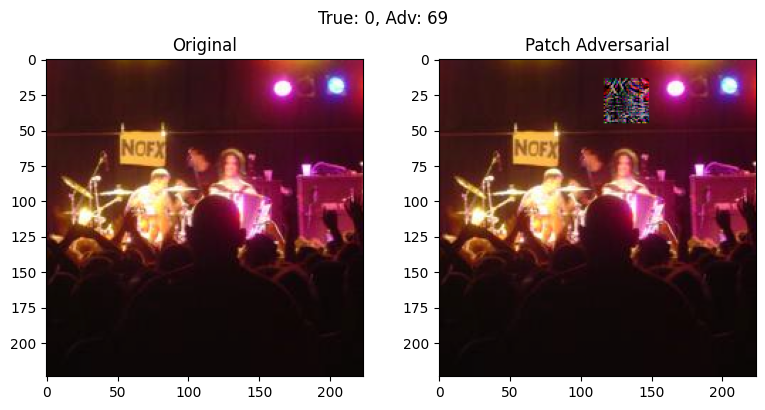

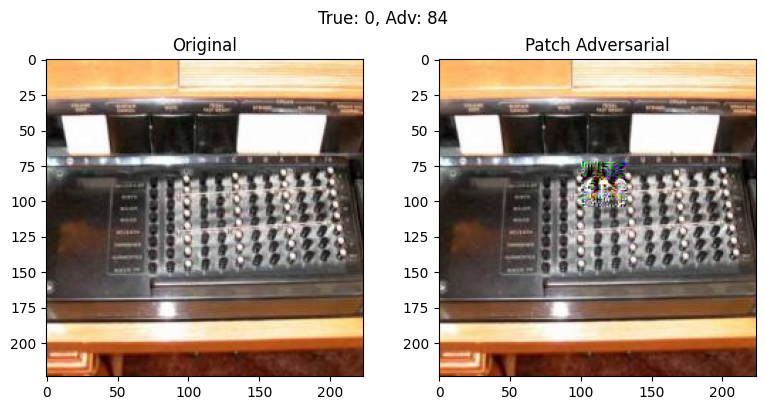

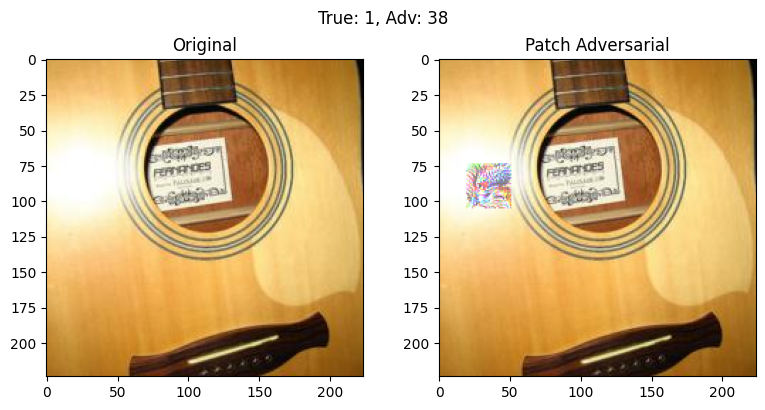

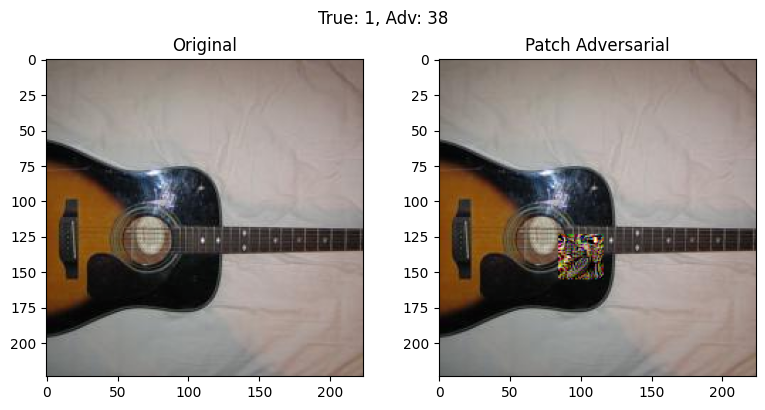

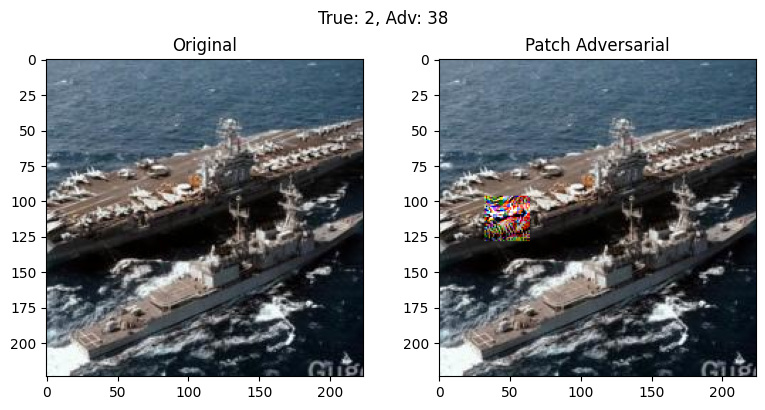


📊 Evaluating patch-based MI-PGD accuracy...

✅ Adversarial Set 3 (Patch MI-PGD, ε = 0.5)
Top-1 Accuracy: 28.80%
Top-5 Accuracy: 88.20%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
import random

# Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load label indices
with open("./TestDataSet/labels_list.json", "r") as f:
    labels = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in labels]

# Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=mean, std=std)
unnormalize = transforms.Normalize(mean=-mean / std, std=1 / std)

to_tensor = transforms.ToTensor()

# # PGD patch parameters
# epsilon = 0.5
# alpha = 0.025
# num_steps = 40
# momentum_coeff = 0.9
# patch_size = 32
# target_class = 7  # Amphibian (distant target)

# PGD patch parameters
epsilon = 0.5           # Max perturbation per pixel (L∞ norm bound); ↑epsilon → stronger but more visible attack
alpha = 0.01            # Step size per PGD iteration; ↑alpha → faster updates, risk overshooting; ↓alpha → slower but more precise
num_steps = 100          # Number of PGD steps; ↑steps → stronger attack, slower runtime; ↓steps → weaker attack, faster
momentum_coeff = 0.9    # Gradient momentum factor; ↑momentum → smoother direction, better transferability; ↓momentum → more local updates
patch_size = 32         # Side of square patch (in pixels); ↑patch_size → larger attack region, stronger effect; ↓patch_size → stealthier but weaker

# Dataset setup
root = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=root, transform=lambda x: x)

# Output dir
adv_save_dir = "Adversarial_Test_Set_3"
os.makedirs(adv_save_dir, exist_ok=True)

adv_images = []
orig_images = []
true_labels = []
adv_labels = []

print("🚀 Running 32x32 patch-based targeted MI-PGD attack...")

for i, (img_pil, label) in enumerate(tqdm(dataset)):
    raw = to_tensor(img_pil).unsqueeze(0).cuda()
    orig = raw.clone()
    _, _, H, W = raw.shape

    # Random patch location
    x = random.randint(0, W - patch_size)
    y = random.randint(0, H - patch_size)

    # Create patch mask
    patch_mask = torch.zeros_like(raw)
    patch_mask[:, :, y:y+patch_size, x:x+patch_size] = 1.0

    perturbed = raw.clone().detach().requires_grad_(True)
    grad_prev = torch.zeros_like(raw)

    for _ in range(num_steps):
        normed = normalize(perturbed)
        output = model(normed)
        masked_output = output[:, imagenet_indices]
        loss = -torch.nn.functional.cross_entropy(masked_output, torch.tensor([target_class]).cuda())

        model.zero_grad()
        loss.backward()

        grad = perturbed.grad.detach()
        grad = grad / (grad.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8)

        # Momentum update
        grad_combined = momentum_coeff * grad_prev + grad
        grad_prev = grad_combined

        # Apply patch-only update
        update = alpha * grad_combined.sign() * patch_mask
        perturbed = perturbed + update

        # L∞ projection
        delta = torch.clamp(perturbed - orig, min=-epsilon, max=epsilon) * patch_mask
        perturbed = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)

    # Save adversarial image
    save_path = os.path.join(adv_save_dir, f"adv_{i:04d}.png")
    save_image(perturbed.detach().cpu().squeeze(), save_path)

    # Evaluation
    normed_adv = normalize(perturbed.detach())
    with torch.no_grad():
        pred = model(normed_adv)
        masked_pred = pred[:, imagenet_indices]
        pred_top1 = masked_pred.argmax(dim=1)

        adv_images.append(normed_adv.cpu())
        orig_images.append(normalize(orig).cpu())
        true_labels.append(label)
        adv_labels.append(pred_top1.item())

print("✅ Adversarial images saved to Adversarial_Test_Set_3.")

# Convert lists to tensors
adv_images = torch.cat(adv_images)
orig_images = torch.cat(orig_images)
true_labels = torch.tensor(true_labels)
adv_labels = torch.tensor(adv_labels)

# Visualize examples
print("\n🔍 Visualizing 32x32 patch adversarial examples:")
misclassified = (adv_labels != true_labels).nonzero(as_tuple=True)[0]
for i in misclassified[:5]:
    orig = unnormalize(orig_images[i]).permute(1, 2, 0).numpy()
    adv = unnormalize(adv_images[i]).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(np.clip(orig, 0, 1))
    axs[0].set_title("Original")
    axs[1].imshow(np.clip(adv, 0, 1))
    axs[1].set_title("Patch Adversarial")
    plt.suptitle(f"True: {true_labels[i].item()}, Adv: {adv_labels[i].item()}")
    plt.tight_layout()
    plt.show()

# Evaluate accuracy
print("\n📊 Evaluating patch-based MI-PGD accuracy...")

top1_correct, top5_correct = 0, 0
total = 0

with torch.no_grad():
    for i in range(0, len(adv_images), 64):
        batch = adv_images[i:i+64].cuda()
        targets = true_labels[i:i+64].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)
        top1 = top5[:, 0]

        top1_correct += (top1 == targets).sum().item()
        top5_correct += sum([targets[j] in top5[j] for j in range(len(targets))])
        total += targets.size(0)

adv_top1_acc = top1_correct / total
adv_top5_acc = top5_correct / total

print(f"\n✅ Adversarial Set 3 (Patch MI-PGD, ε = {epsilon})")
print(f"Top-1 Accuracy: {adv_top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc * 100:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 16.2MB/s]


🚀 Running 32x32 patch-based attack targeting top-5 accuracy with 5 random restarts...


100%|██████████| 500/500 [1:05:39<00:00,  7.88s/it]


✅ Adversarial images saved to: Adversarial_Test_Set_3

🔍 Visualizing patch adversarial examples with true class removed from top-5:


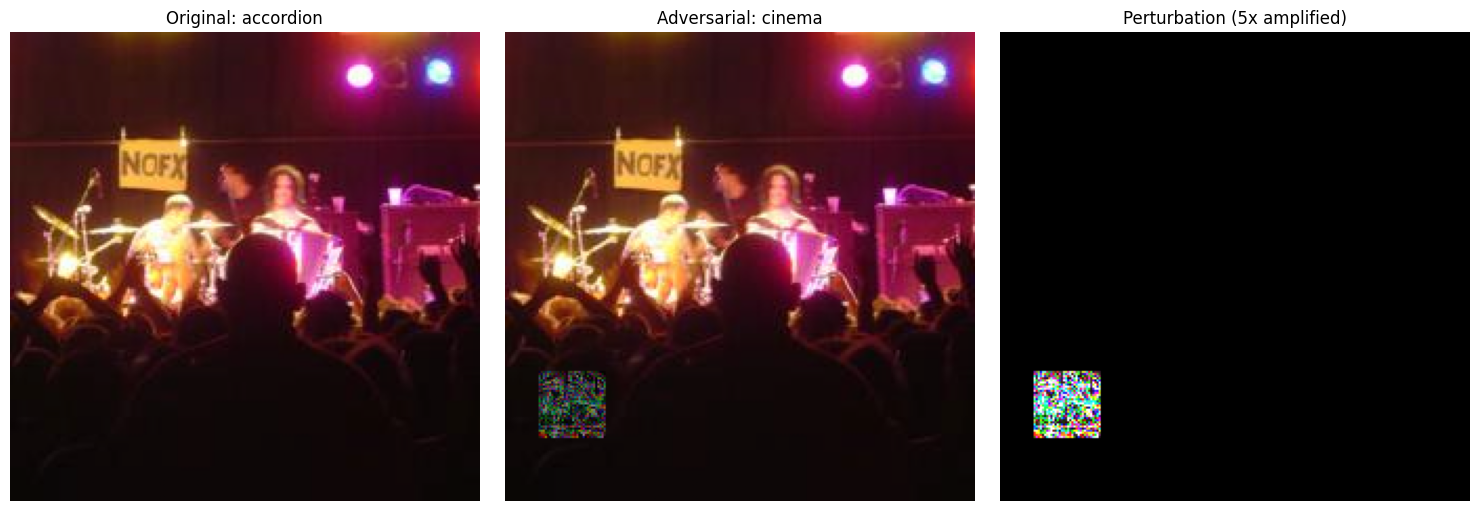

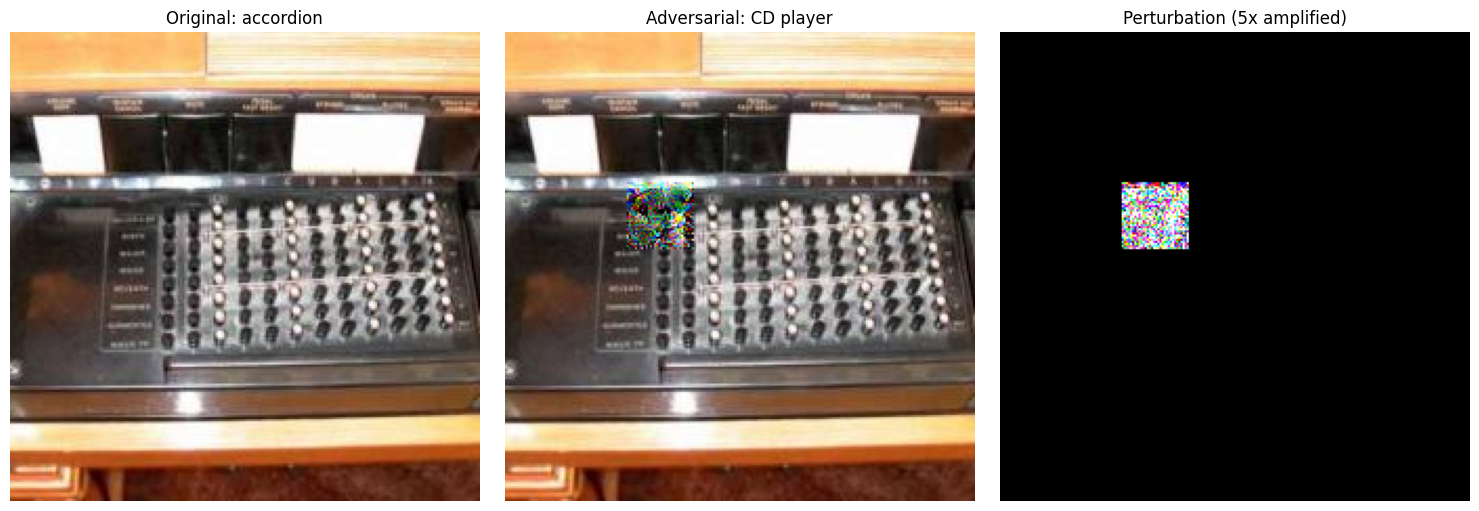

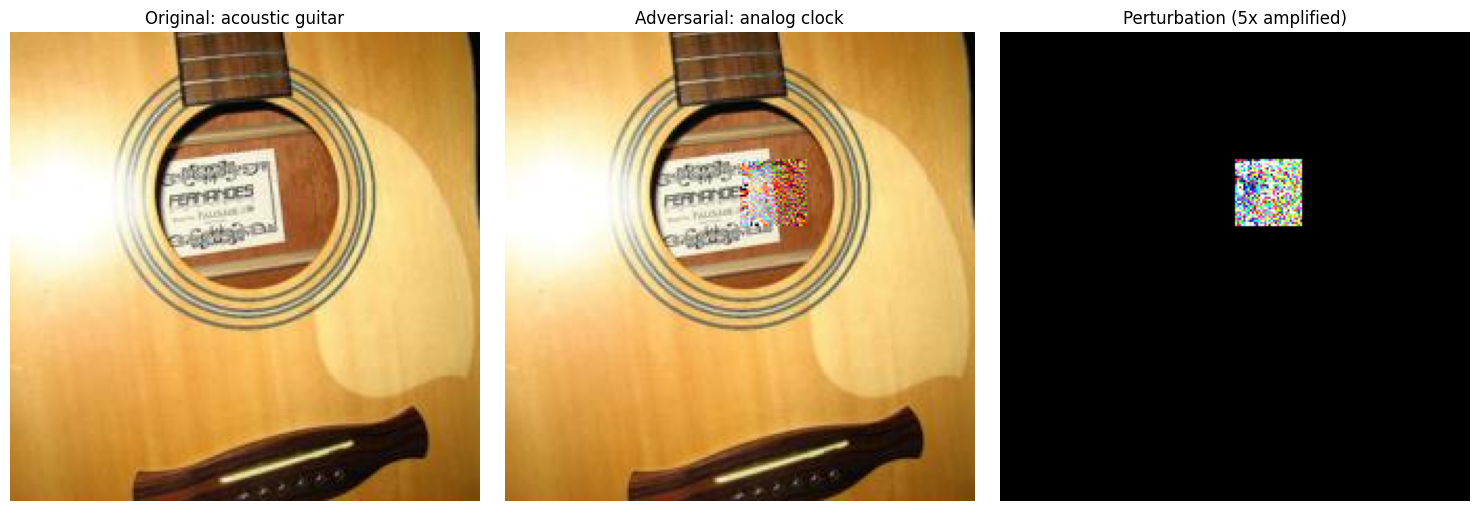

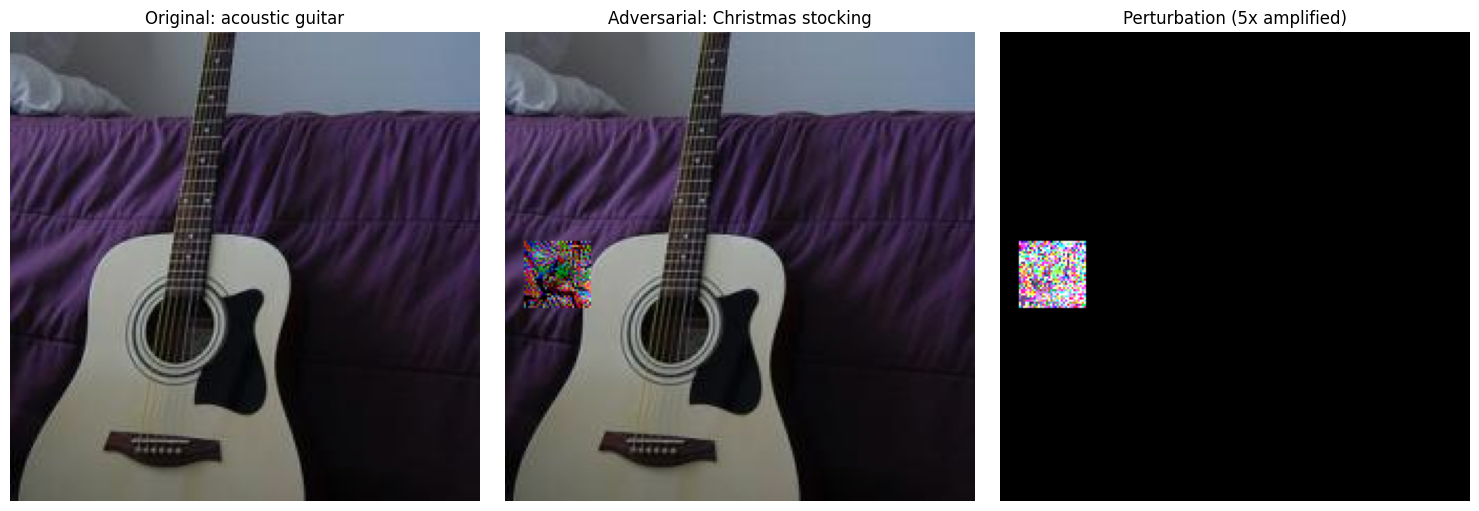

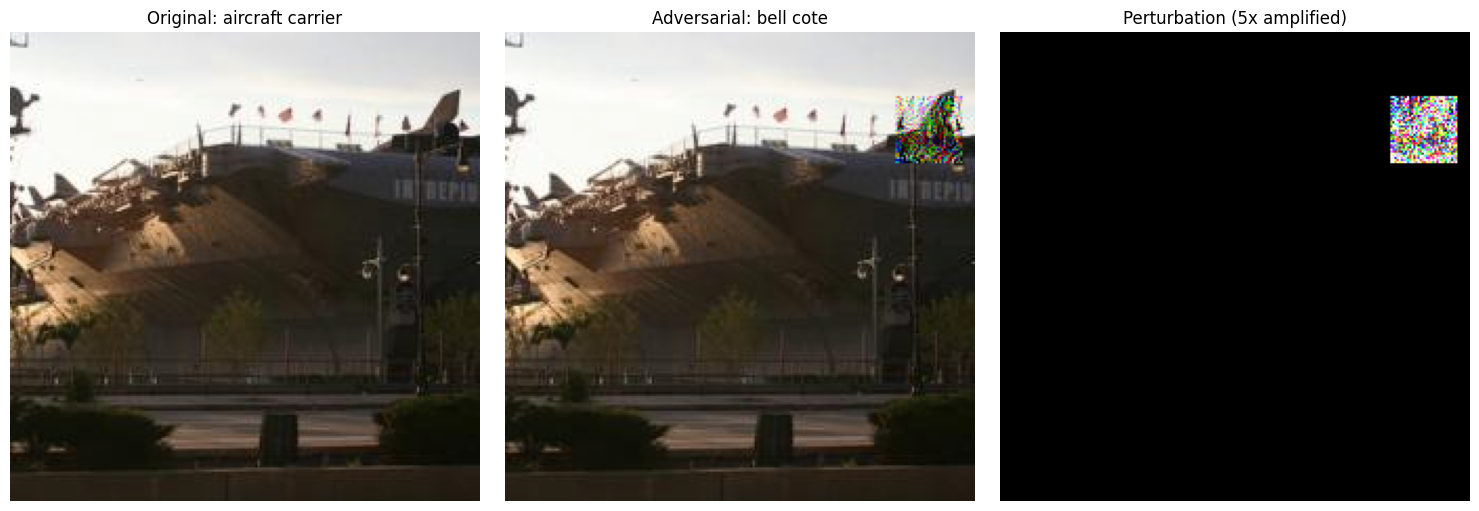


📊 Evaluating patch-based PGD accuracy...

✅ Adversarial Test Set 3 (Patch-based attack, ε = 0.5)
Top-1 Accuracy: 11.20%
Top-5 Accuracy: 60.40%
Top-1 Attack Success Rate: 88.80%
Top-5 Attack Success Rate: 39.60%


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
import random

# Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load label indices
with open("/content/TestData/labels_list.json", "r") as f:
    labels = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in labels]
class_names = [x.split(":")[1].strip() for x in labels]

# Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=mean, std=std)
unnormalize = transforms.Normalize(mean=-mean / std, std=1 / std)

to_tensor = transforms.ToTensor()

# PGD patch parameters
epsilon = 0.5
alpha = 0.01
num_steps = 100
patch_size = 32
num_restarts = 5
target_top5 = True  # Target removal from top-5 specifically

# Dataset setup
root = "/content/TestData"
dataset = torchvision.datasets.ImageFolder(root=root, transform=lambda x: x)

# Output dir
adv_save_dir = "Adversarial_Test_Set_3"  # Following assignment naming
os.makedirs(adv_save_dir, exist_ok=True)

adv_images = []
orig_images = []
true_labels = []
adv_labels = []

print(f"🚀 Running 32x32 patch-based attack targeting top-5 accuracy with {num_restarts} random restarts...")

for i, (img_pil, label) in enumerate(tqdm(dataset)):
    raw = to_tensor(img_pil).unsqueeze(0).cuda()
    orig = raw.clone()
    _, _, H, W = raw.shape

    # Random patch location
    x = random.randint(0, W - patch_size)
    y = random.randint(0, H - patch_size)

    # Create patch mask
    patch_mask = torch.zeros_like(raw)
    patch_mask[:, :, y:y+patch_size, x:x+patch_size] = 1.0

    best_adv = orig.clone()

    # For target_top5, we track success rate at removing true class from top-5
    if target_top5:
        best_success = False  # Track if we've found a successful example yet
        best_loss = torch.tensor(float("inf")).cuda()  # Lower is better for targeted
    else:
        # For standard untargeted attack (maximize cross-entropy)
        best_loss = torch.tensor(-float("inf")).cuda()  # Higher is better

    for restart in range(num_restarts):
        # Initialize with random noise in the patch area
        rand_noise = torch.empty_like(raw).uniform_(-epsilon, epsilon) * patch_mask
        perturbed = torch.clamp(orig + rand_noise, 0, 1).detach().requires_grad_(True)

        for step in range(num_steps):
            normed = normalize(perturbed)
            output = model(normed)
            masked_output = output[:, imagenet_indices]

            if target_top5:
                # Get all classes except the true class
                all_classes = torch.arange(len(imagenet_indices), device='cuda')
                wrong_classes = all_classes[all_classes != label]

                # Randomly select 5 wrong classes to promote
                num_targets = min(5, len(wrong_classes))
                target_classes = wrong_classes[torch.randperm(len(wrong_classes))[:num_targets]]

                # Compute softmax probabilities
                probs = torch.softmax(masked_output.squeeze(), dim=0)

                # Loss: minimize probability of true class, maximize for target classes
                true_prob = probs[label]
                target_probs = probs[target_classes].sum()

                # We want to maximize target_probs and minimize true_prob
                loss = true_prob - target_probs
            else:
                # Standard untargeted attack
                loss = torch.nn.functional.cross_entropy(masked_output, torch.tensor([label]).cuda())

            model.zero_grad()
            loss.backward()

            # Gradient normalization for stability
            grad = perturbed.grad.detach()
            grad = grad / (grad.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8)

            # For target_top5, move in opposite direction of gradient (to minimize loss)
            if target_top5:
                update = -alpha * grad.sign() * patch_mask
            else:
                update = alpha * grad.sign() * patch_mask

            perturbed = perturbed + update

            # Project back to epsilon-ball and valid image range
            delta = torch.clamp(perturbed - orig, min=-epsilon, max=epsilon) * patch_mask
            perturbed = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)

        # Evaluate this restart
        normed_final = normalize(perturbed.detach())
        with torch.no_grad():
            final_output = model(normed_final)[:, imagenet_indices]

            if target_top5:
                # Check if true class is removed from top-5
                _, top5 = final_output.topk(5, dim=1)
                true_class_removed = label not in top5.squeeze()

                # If we've found a successful example, use it
                if true_class_removed and not best_success:
                    best_success = True
                    best_adv = perturbed.detach()
                    best_loss = loss.detach()
                # If we already have success, take the one with better loss
                elif true_class_removed and best_success and loss < best_loss:
                    best_adv = perturbed.detach()
                    best_loss = loss.detach()
                # If we haven't found success yet, take the best attempt
                elif not best_success and loss < best_loss:
                    best_adv = perturbed.detach()
                    best_loss = loss.detach()
            else:
                # For untargeted, take highest loss
                final_loss = torch.nn.functional.cross_entropy(final_output, torch.tensor([label]).cuda())
                if final_loss > best_loss:
                    best_loss = final_loss
                    best_adv = perturbed.detach()

    # Save adversarial image
    save_path = os.path.join(adv_save_dir, f"adv_{i:04d}.png")
    save_image(best_adv.cpu().squeeze(), save_path)

    # Evaluation
    normed_adv = normalize(best_adv)
    with torch.no_grad():
        pred = model(normed_adv)
        masked_pred = pred[:, imagenet_indices]
        pred_top1 = masked_pred.argmax(dim=1)

        adv_images.append(normed_adv.cpu())
        orig_images.append(normalize(orig).cpu())
        true_labels.append(label)
        adv_labels.append(pred_top1.item())

print("✅ Adversarial images saved to:", adv_save_dir)

# Convert lists to tensors
adv_images = torch.cat(adv_images)
orig_images = torch.cat(orig_images)
true_labels = torch.tensor(true_labels)
adv_labels = torch.tensor(adv_labels)

# Visualize examples - focusing on top-5 removal success
print("\n🔍 Visualizing patch adversarial examples with true class removed from top-5:")

success_indices = []
with torch.no_grad():
    for i in range(len(adv_images)):
        batch = adv_images[i].unsqueeze(0).cuda()
        target = true_labels[i].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)
        if target not in top5[0]:
            success_indices.append(i)
            if len(success_indices) >= 5:  # Get first 5 successful examples
                break

# If we don't have enough successful top-5 removals, fall back to top-1 misclassifications
if len(success_indices) < 5:
    misclassified = (adv_labels != true_labels).nonzero(as_tuple=True)[0]
    remaining_needed = 5 - len(success_indices)
    for i in misclassified:
        if i not in success_indices:
            success_indices.append(i)
            remaining_needed -= 1
            if remaining_needed == 0:
                break

# Visualize examples
for i in success_indices[:5]:
    orig = unnormalize(orig_images[i]).permute(1, 2, 0).numpy()
    adv = unnormalize(adv_images[i]).permute(1, 2, 0).numpy()
    diff = np.abs(adv - orig) * 5  # Amplify difference to visualize patch

    # Get model predictions
    with torch.no_grad():
        # Original image
        orig_output = model(orig_images[i].unsqueeze(0).cuda())
        orig_masked = orig_output[:, imagenet_indices]
        _, orig_top5 = orig_masked.topk(5, dim=1)
        orig_top5_labels = [class_names[idx] for idx in orig_top5[0].cpu().numpy()]

        # Adversarial image
        adv_output = model(adv_images[i].unsqueeze(0).cuda())
        adv_masked = adv_output[:, imagenet_indices]
        _, adv_top5 = adv_masked.topk(5, dim=1)
        adv_top5_labels = [class_names[idx] for idx in adv_top5[0].cpu().numpy()]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.clip(orig, 0, 1))
    axs[0].set_title(f"Original: {class_names[true_labels[i]]}")
    axs[0].set_xlabel(f"Top-5: {', '.join(orig_top5_labels)}")
    axs[0].axis('off')

    axs[1].imshow(np.clip(adv, 0, 1))
    axs[1].set_title(f"Adversarial: {class_names[adv_labels[i]]}")
    axs[1].set_xlabel(f"Top-5: {', '.join(adv_top5_labels)}")
    axs[1].axis('off')

    axs[2].imshow(diff)
    axs[2].set_title("Perturbation (5x amplified)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(adv_save_dir, f"example_{i:04d}.png"))
    plt.show()

# Evaluate accuracy
print("\n📊 Evaluating patch-based PGD accuracy...")

top1_correct, top5_correct = 0, 0
total = 0

with torch.no_grad():
    for i in range(0, len(adv_images), 64):
        batch = adv_images[i:i+64].cuda()
        targets = true_labels[i:i+64].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)
        top1 = top5[:, 0]

        top1_correct += (top1 == targets).sum().item()
        top5_correct += sum([targets[j] in top5[j] for j in range(len(targets))])
        total += targets.size(0)

adv_top1_acc = top1_correct / total
adv_top5_acc = top5_correct / total

# Calculate attack success rates
top1_success_rate = 1 - adv_top1_acc
top5_success_rate = 1 - adv_top5_acc

print(f"\n✅ Adversarial Test Set 3 (Patch-based attack, ε = {epsilon})")
print(f"Top-1 Accuracy: {adv_top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc * 100:.2f}%")
print(f"Top-1 Attack Success Rate: {top1_success_rate * 100:.2f}%")
print(f"Top-5 Attack Success Rate: {top5_success_rate * 100:.2f}%")

🚀 Running dual-objective single patch attack targeting both top-1 and top-5 accuracy...
Parameters: ε=0.5, patch_size=32, steps=150, restarts=8


100%|██████████| 500/500 [2:38:15<00:00, 18.99s/it]


✅ Adversarial images saved to: Adversarial_Test_Set_3

🔍 Visualizing dual objective attack examples:


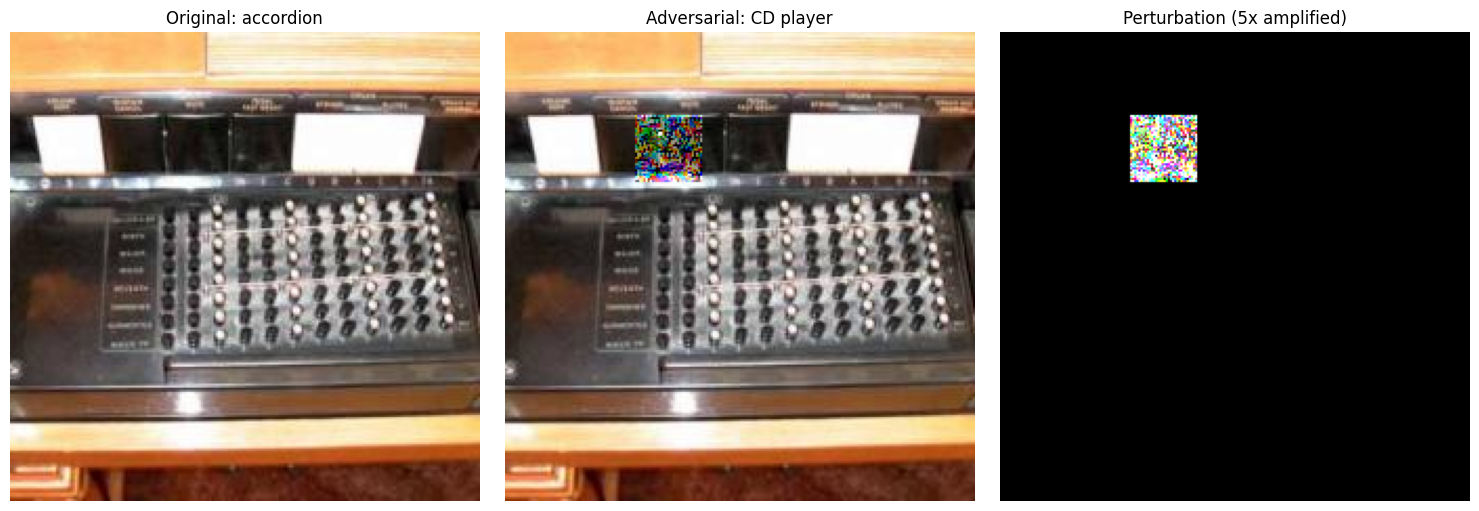

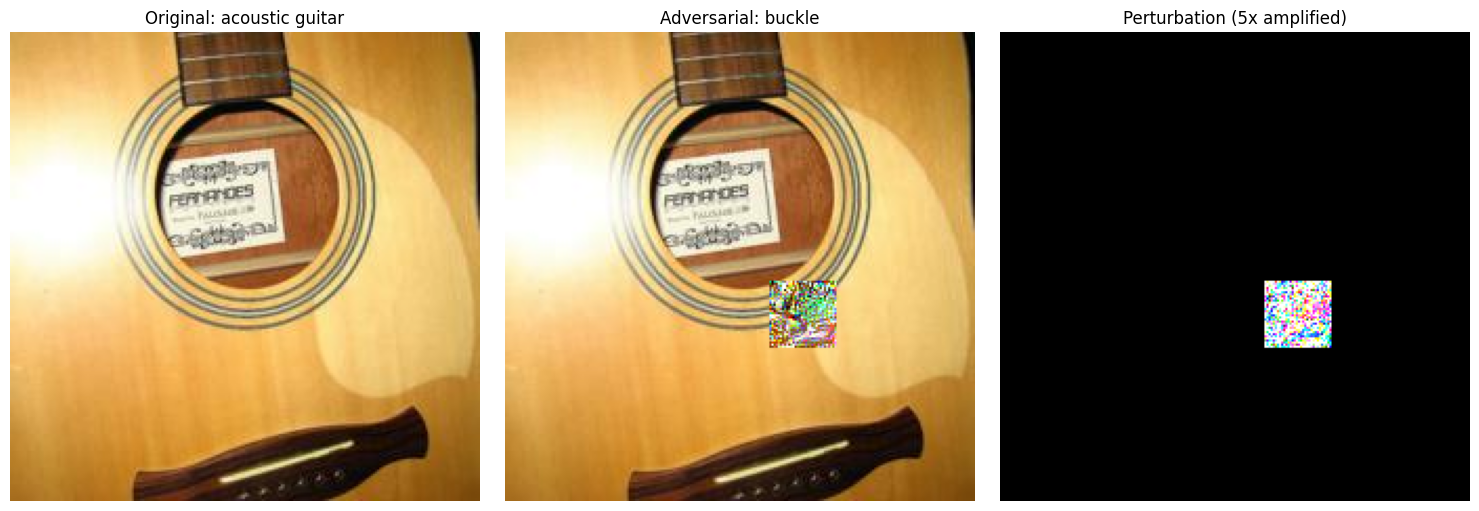

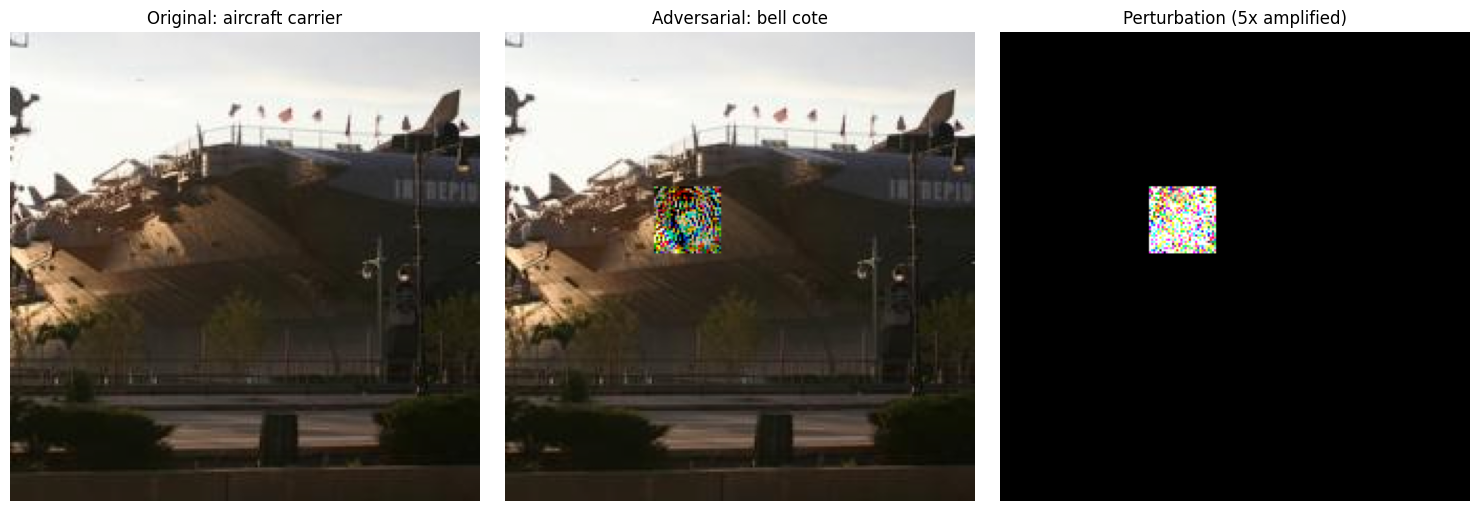

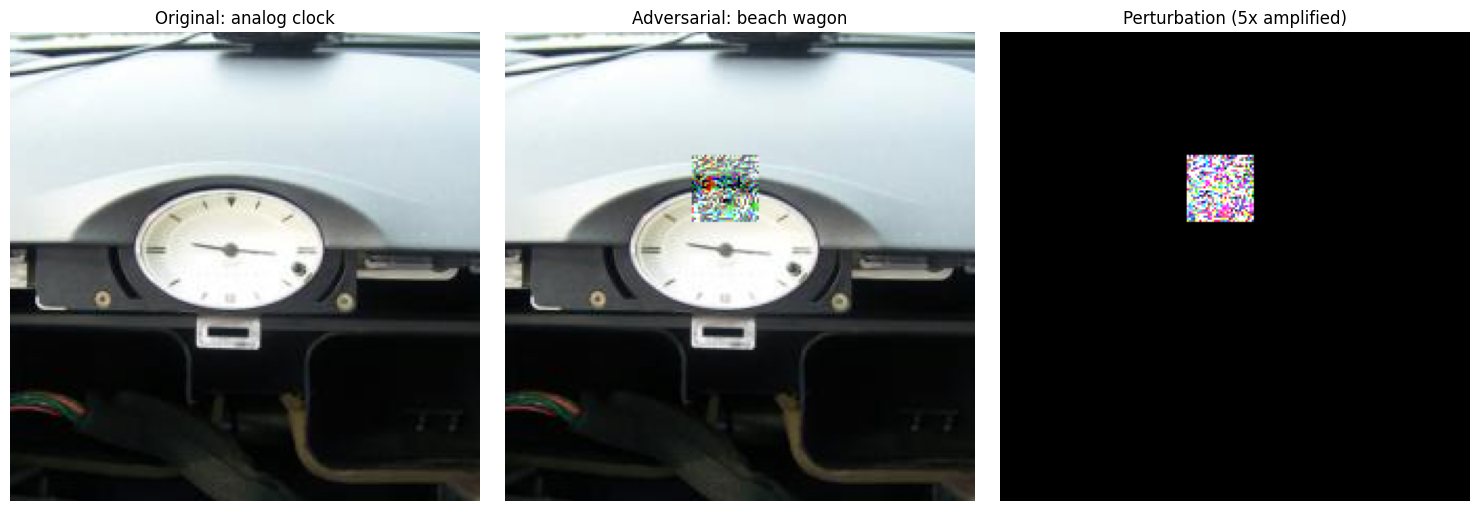

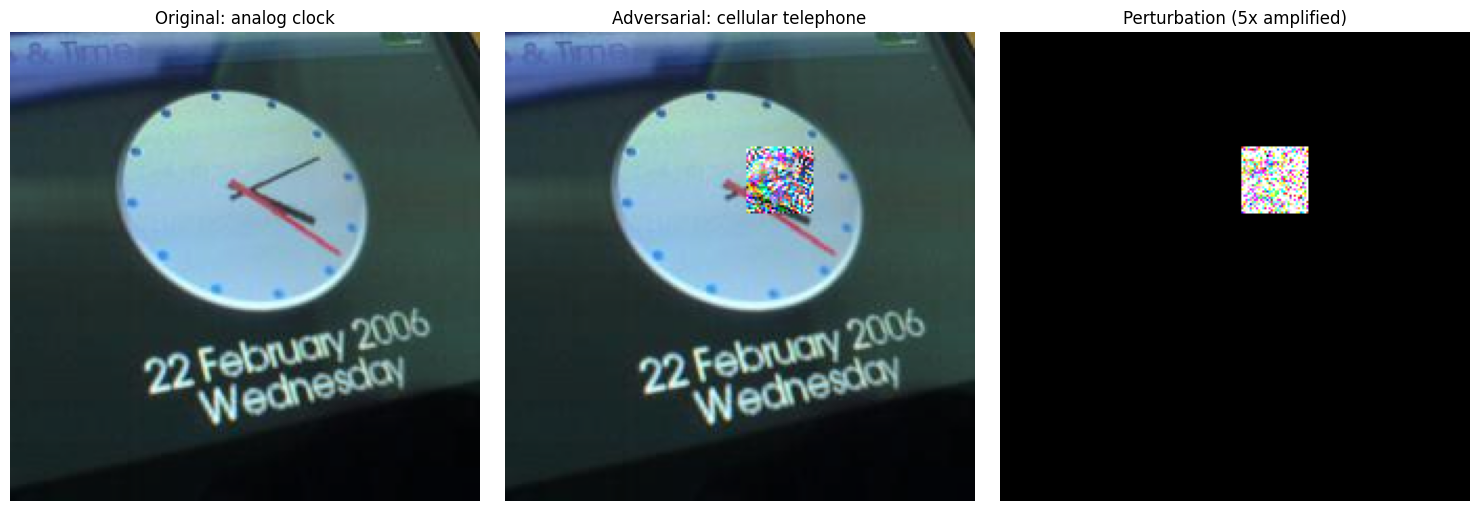


📊 Evaluating dual-objective patch attack accuracy...

✅ Adversarial Test Set 3 (Dual-objective patch attack, ε = 0.5)
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%
Top-1 Attack Success Rate: 97.20%
Top-5 Attack Success Rate: 15.40%


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
import random

# Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load label indices
with open("/content/TestData/labels_list.json", "r") as f:
    labels = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in labels]
class_names = [x.split(":")[1].strip() for x in labels]

# Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=mean, std=std)
unnormalize = transforms.Normalize(mean=-mean / std, std=1 / std)

to_tensor = transforms.ToTensor()

# Enhanced PGD patch parameters
epsilon = 0.5  # Increased from 0.5
alpha = 0.015  # Increased from 0.01
num_steps = 150  # Increased from 100
patch_size = 32  # Increased from 32
num_restarts = 8  # Increased from 5

# Dataset setup
root = "/content/TestData"
dataset = torchvision.datasets.ImageFolder(root=root, transform=lambda x: x)

# Output dir
adv_save_dir = "Adversarial_Test_Set_3"
os.makedirs(adv_save_dir, exist_ok=True)

adv_images = []
orig_images = []
true_labels = []
adv_labels = []

print(f"🚀 Running dual-objective single patch attack targeting both top-1 and top-5 accuracy...")
print(f"Parameters: ε={epsilon}, patch_size={patch_size}, steps={num_steps}, restarts={num_restarts}")

for i, (img_pil, label) in enumerate(tqdm(dataset)):
    raw = to_tensor(img_pil).unsqueeze(0).cuda()
    orig = raw.clone()
    _, _, H, W = raw.shape

    # Create patch mask with center bias
    patch_mask = torch.zeros_like(raw)

    # Single patch - biased toward center
    center_x, center_y = W//2, H//2
    max_offset = min(W, H)//4
    x = center_x + random.randint(-max_offset, max_offset) - patch_size//2
    y = center_y + random.randint(-max_offset, max_offset) - patch_size//2
    x = max(0, min(W-patch_size, x))
    y = max(0, min(H-patch_size, y))
    patch_mask[:, :, y:y+patch_size, x:x+patch_size] = 1.0

    best_adv = orig.clone()
    best_dual_score = torch.tensor(-float("inf")).cuda()

    # Find initial strong classes for this image
    with torch.no_grad():
        initial_output = model(normalize(orig))[:, imagenet_indices]
        initial_probs = torch.softmax(initial_output.squeeze(), dim=0)

        # Get top predicted classes excluding true class
        initial_probs[label] = 0  # Zero out true class
        confusing_classes = initial_probs.argsort(descending=True)[:5]

    # Initialize momentum
    momentum = torch.zeros_like(orig).cuda()

    for restart in range(num_restarts):
        # Use decay for learning rate
        alpha_schedule = lambda step: alpha * (1.0 - step/num_steps)

        # Initialize with random noise in patch area
        rand_noise = torch.empty_like(raw).uniform_(-epsilon, epsilon) * patch_mask
        perturbed = torch.clamp(orig + rand_noise, 0, 1).detach().requires_grad_(True)

        # Reset momentum for each restart
        momentum = torch.zeros_like(orig).cuda()

        for step in range(num_steps):
            # Current alpha value
            current_alpha = alpha_schedule(step)

            normed = normalize(perturbed)
            output = model(normed)
            masked_output = output[:, imagenet_indices]

            # Calculate dual-objective loss
            probs = torch.softmax(masked_output.squeeze(), dim=0)

            # 1. Top-1 loss: Make strongest incorrect class stronger than true class
            strongest_incorrect = confusing_classes[0]  # Use precomputed confusing class
            top1_margin = probs[strongest_incorrect] - probs[label]

            # 2. Top-5 loss: Promote multiple confusing classes
            top5_probs = probs[confusing_classes].sum()
            true_prob = probs[label]

            # Combined loss with weighting (negative because we want to maximize)
            loss = -(0.6 * top1_margin + 0.4 * (top5_probs - true_prob))

            model.zero_grad()
            loss.backward()

            # Apply momentum to gradient
            grad = perturbed.grad.detach()
            momentum = 0.9 * momentum - 0.1 * grad

            # Normalize gradient
            momentum_norm = momentum / (momentum.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8)

            # Update
            update = current_alpha * momentum_norm.sign() * patch_mask
            perturbed = perturbed + update

            # Project back to epsilon-ball and valid image range
            delta = torch.clamp(perturbed - orig, min=-epsilon, max=epsilon) * patch_mask
            perturbed = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)

        # Evaluate this restart
        normed_final = normalize(perturbed.detach())
        with torch.no_grad():
            final_output = model(normed_final)[:, imagenet_indices]
            final_probs = torch.softmax(final_output.squeeze(), dim=0)

            # Get top-1 and top-5
            _, top5 = final_output.topk(5, dim=1)

            # Calculate dual scoring metric:
            # 1. Is true class not top-1? (1 if success, 0 if failure)
            top1_success = 1.0 if top5[0, 0] != label else 0.0

            # 2. Is true class not in top-5? (1 if success, 0 if failure)
            top5_success = 1.0 if label not in top5 else 0.0

            # Combined score weighted toward top-1 (more important)
            dual_score = top1_success * 0.6 + top5_success * 0.4

            # If multiple restarts have same success level, select by probability margin
            if dual_score == best_dual_score:
                # Compare probability margins
                new_margin = final_probs[confusing_classes[0]] - final_probs[label]

                with torch.no_grad():
                    best_output = model(normalize(best_adv))[:, imagenet_indices]
                    best_probs = torch.softmax(best_output.squeeze(), dim=0)
                    best_margin = best_probs[confusing_classes[0]] - best_probs[label]

                if new_margin > best_margin:
                    best_adv = perturbed.detach()
            elif dual_score > best_dual_score:
                best_dual_score = dual_score
                best_adv = perturbed.detach()

    # Save adversarial image
    save_path = os.path.join(adv_save_dir, f"adv_{i:04d}.png")
    save_image(best_adv.cpu().squeeze(), save_path)

    # Evaluation
    normed_adv = normalize(best_adv)
    with torch.no_grad():
        pred = model(normed_adv)
        masked_pred = pred[:, imagenet_indices]
        pred_top1 = masked_pred.argmax(dim=1)

        adv_images.append(normed_adv.cpu())
        orig_images.append(normalize(orig).cpu())
        true_labels.append(label)
        adv_labels.append(pred_top1.item())

print("✅ Adversarial images saved to:", adv_save_dir)

# Convert lists to tensors
adv_images = torch.cat(adv_images)
orig_images = torch.cat(orig_images)
true_labels = torch.tensor(true_labels)
adv_labels = torch.tensor(adv_labels)

# Visualize examples - focusing on dual success
print("\n🔍 Visualizing dual objective attack examples:")

success_indices = []
with torch.no_grad():
    for i in range(len(adv_images)):
        batch = adv_images[i].unsqueeze(0).cuda()
        target = true_labels[i].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)
        top1 = top5[0, 0]

        # Check if attack succeeded for both objectives
        if top1 != target and target not in top5[0]:
            success_indices.append(i)
            if len(success_indices) >= 5:  # Get first 5 successful examples
                break

# If we don't have enough dual successes, fall back to top-1 misclassifications
if len(success_indices) < 5:
    misclassified = (adv_labels != true_labels).nonzero(as_tuple=True)[0]
    remaining_needed = 5 - len(success_indices)
    for i in misclassified:
        if i not in success_indices:
            success_indices.append(i)
            remaining_needed -= 1
            if remaining_needed == 0:
                break

# Visualize examples
for i in success_indices[:5]:
    orig = unnormalize(orig_images[i]).permute(1, 2, 0).numpy()
    adv = unnormalize(adv_images[i]).permute(1, 2, 0).numpy()
    diff = np.abs(adv - orig) * 5  # Amplify difference to visualize patch

    # Get model predictions
    with torch.no_grad():
        # Original image
        orig_output = model(orig_images[i].unsqueeze(0).cuda())
        orig_masked = orig_output[:, imagenet_indices]
        _, orig_top5 = orig_masked.topk(5, dim=1)
        orig_top5_labels = [class_names[idx] for idx in orig_top5[0].cpu().numpy()]

        # Adversarial image
        adv_output = model(adv_images[i].unsqueeze(0).cuda())
        adv_masked = adv_output[:, imagenet_indices]
        _, adv_top5 = adv_masked.topk(5, dim=1)
        adv_top5_labels = [class_names[idx] for idx in adv_top5[0].cpu().numpy()]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.clip(orig, 0, 1))
    axs[0].set_title(f"Original: {class_names[true_labels[i]]}")
    axs[0].set_xlabel(f"Top-5: {', '.join(orig_top5_labels)}")
    axs[0].axis('off')

    axs[1].imshow(np.clip(adv, 0, 1))
    axs[1].set_title(f"Adversarial: {class_names[adv_labels[i]]}")
    axs[1].set_xlabel(f"Top-5: {', '.join(adv_top5_labels)}")
    axs[1].axis('off')

    axs[2].imshow(diff)
    axs[2].set_title("Perturbation (5x amplified)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(adv_save_dir, f"example_{i:04d}.png"))
    plt.show()

# Evaluate accuracy
print("\n📊 Evaluating dual-objective patch attack accuracy...")

top1_correct, top5_correct = 0, 0
total = 0

with torch.no_grad():
    for i in range(0, len(adv_images), 64):
        batch = adv_images[i:i+64].cuda()
        targets = true_labels[i:i+64].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)
        top1 = top5[:, 0]

        top1_correct += (top1 == targets).sum().item()
        top5_correct += sum([targets[j] in top5[j] for j in range(len(targets))])
        total += targets.size(0)

adv_top1_acc = top1_correct / total
adv_top5_acc = top5_correct / total

# Calculate attack success rates
top1_success_rate = 1 - adv_top1_acc
top5_success_rate = 1 - adv_top5_acc

print(f"\n✅ Adversarial Test Set 3 (Dual-objective patch attack, ε = {epsilon})")
print(f"Top-1 Accuracy: {adv_top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc * 100:.2f}%")
print(f"Top-1 Attack Success Rate: {top1_success_rate * 100:.2f}%")
print(f"Top-5 Attack Success Rate: {top5_success_rate * 100:.2f}%")

🚀 Running mixed precision patch attack targeting both top-1 and top-5 accuracy...
Parameters: ε=0.5, patch_size=32, steps=100, restarts=8
Using automatic mixed precision for faster processing


  0%|          | 1/500 [00:16<2:16:07, 16.37s/it]

Processed 0 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


  2%|▏         | 11/500 [03:00<2:13:51, 16.42s/it]

Processed 10 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


  4%|▍         | 21/500 [05:46<2:12:16, 16.57s/it]

Processed 20 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


  6%|▌         | 31/500 [08:31<2:09:18, 16.54s/it]

Processed 30 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


  8%|▊         | 41/500 [11:17<2:07:05, 16.61s/it]

Processed 40 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 10%|█         | 51/500 [14:03<2:04:23, 16.62s/it]

Processed 50 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 12%|█▏        | 61/500 [16:51<2:02:31, 16.75s/it]

Processed 60 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 14%|█▍        | 71/500 [19:37<1:58:56, 16.64s/it]

Processed 70 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 16%|█▌        | 81/500 [22:22<1:55:54, 16.60s/it]

Processed 80 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 18%|█▊        | 91/500 [25:07<1:52:06, 16.45s/it]

Processed 90 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 20%|██        | 101/500 [27:52<1:50:03, 16.55s/it]

Processed 100 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 22%|██▏       | 111/500 [30:37<1:46:33, 16.43s/it]

Processed 110 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 24%|██▍       | 121/500 [33:22<1:44:03, 16.47s/it]

Processed 120 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 26%|██▌       | 131/500 [36:06<1:40:56, 16.41s/it]

Processed 130 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 28%|██▊       | 141/500 [38:50<1:38:32, 16.47s/it]

Processed 140 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 30%|███       | 151/500 [41:35<1:35:43, 16.46s/it]

Processed 150 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 32%|███▏      | 161/500 [44:20<1:33:16, 16.51s/it]

Processed 160 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 34%|███▍      | 171/500 [47:05<1:30:10, 16.44s/it]

Processed 170 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 36%|███▌      | 181/500 [49:50<1:27:47, 16.51s/it]

Processed 180 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 38%|███▊      | 191/500 [52:37<1:25:47, 16.66s/it]

Processed 190 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 40%|████      | 201/500 [55:22<1:21:35, 16.37s/it]

Processed 200 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 42%|████▏     | 211/500 [58:06<1:19:17, 16.46s/it]

Processed 210 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 44%|████▍     | 221/500 [1:00:52<1:16:26, 16.44s/it]

Processed 220 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 46%|████▌     | 231/500 [1:03:38<1:14:05, 16.53s/it]

Processed 230 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 48%|████▊     | 241/500 [1:06:24<1:11:36, 16.59s/it]

Processed 240 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 50%|█████     | 251/500 [1:09:11<1:09:30, 16.75s/it]

Processed 250 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 52%|█████▏    | 261/500 [1:11:57<1:06:06, 16.60s/it]

Processed 260 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 54%|█████▍    | 271/500 [1:14:42<1:03:15, 16.57s/it]

Processed 270 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 56%|█████▌    | 281/500 [1:17:27<1:00:23, 16.55s/it]

Processed 280 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 58%|█████▊    | 291/500 [1:20:13<57:48, 16.60s/it]

Processed 290 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 60%|██████    | 301/500 [1:22:59<55:11, 16.64s/it]

Processed 300 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 62%|██████▏   | 311/500 [1:25:44<51:55, 16.49s/it]

Processed 310 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 64%|██████▍   | 321/500 [1:28:31<49:56, 16.74s/it]

Processed 320 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 66%|██████▌   | 331/500 [1:31:16<46:18, 16.44s/it]

Processed 330 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 68%|██████▊   | 341/500 [1:34:02<44:04, 16.63s/it]

Processed 340 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 70%|███████   | 351/500 [1:36:47<40:58, 16.50s/it]

Processed 350 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 72%|███████▏  | 361/500 [1:39:32<38:04, 16.44s/it]

Processed 360 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 74%|███████▍  | 371/500 [1:42:19<35:42, 16.61s/it]

Processed 370 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 76%|███████▌  | 381/500 [1:45:04<32:43, 16.50s/it]

Processed 380 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 78%|███████▊  | 391/500 [1:47:50<30:11, 16.62s/it]

Processed 390 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 80%|████████  | 401/500 [1:50:37<27:30, 16.68s/it]

Processed 400 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 82%|████████▏ | 411/500 [1:53:25<24:56, 16.81s/it]

Processed 410 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 84%|████████▍ | 421/500 [1:56:11<22:01, 16.72s/it]

Processed 420 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 86%|████████▌ | 431/500 [1:58:59<19:18, 16.79s/it]

Processed 430 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 88%|████████▊ | 441/500 [2:01:49<16:57, 17.25s/it]

Processed 440 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 90%|█████████ | 451/500 [2:04:37<13:44, 16.82s/it]

Processed 450 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 92%|█████████▏| 461/500 [2:07:25<10:56, 16.83s/it]

Processed 460 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 94%|█████████▍| 471/500 [2:10:12<08:03, 16.68s/it]

Processed 470 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 96%|█████████▌| 481/500 [2:13:01<05:21, 16.92s/it]

Processed 480 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


 98%|█████████▊| 491/500 [2:15:49<02:30, 16.72s/it]

Processed 490 images
Top-1 Accuracy: 2.80%
Top-5 Accuracy: 84.60%


100%|██████████| 500/500 [2:18:20<00:00, 16.60s/it]


✅ Adversarial images saved to: Adversarial_Test_Set_3

🔍 Visualizing examples where true class is removed from top-5:


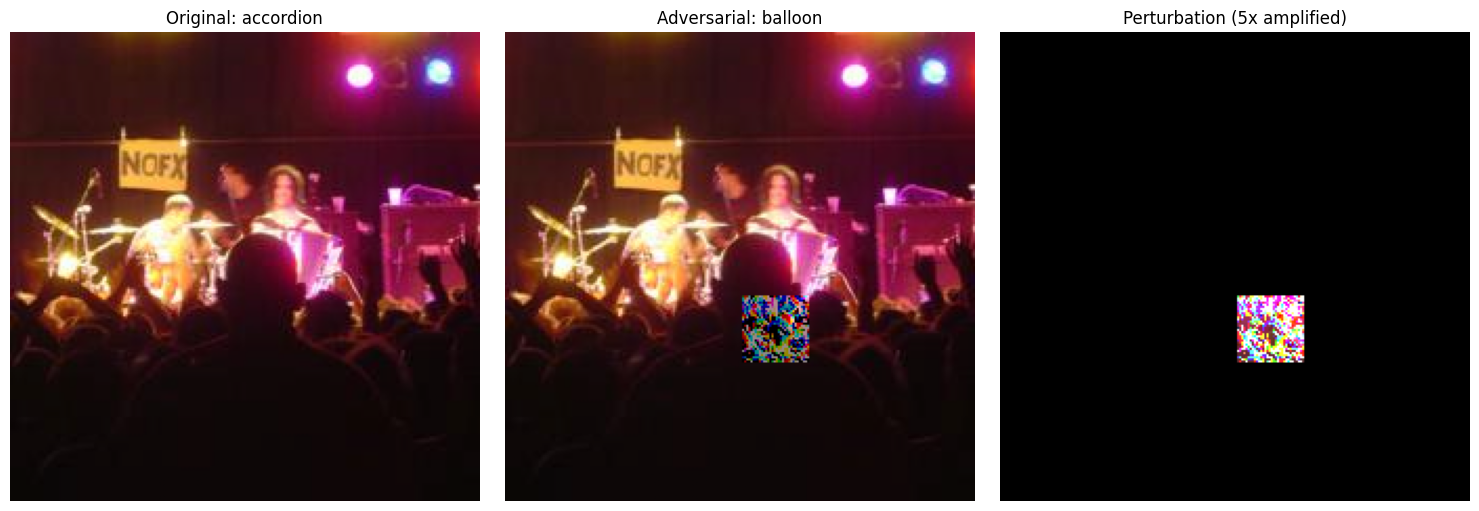

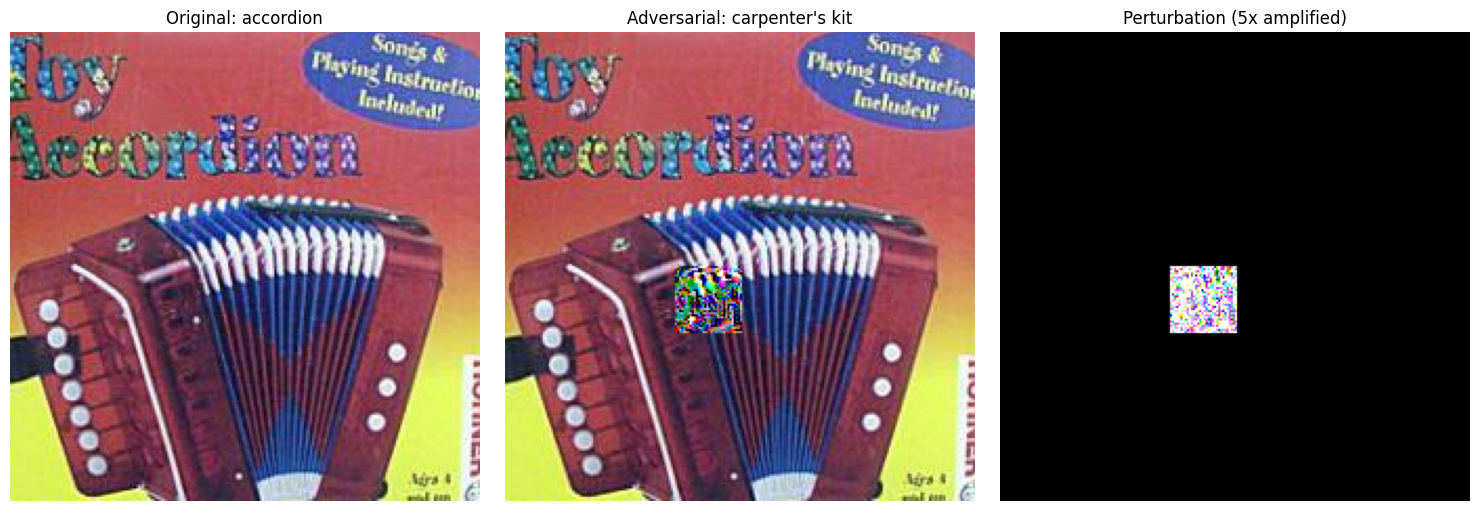

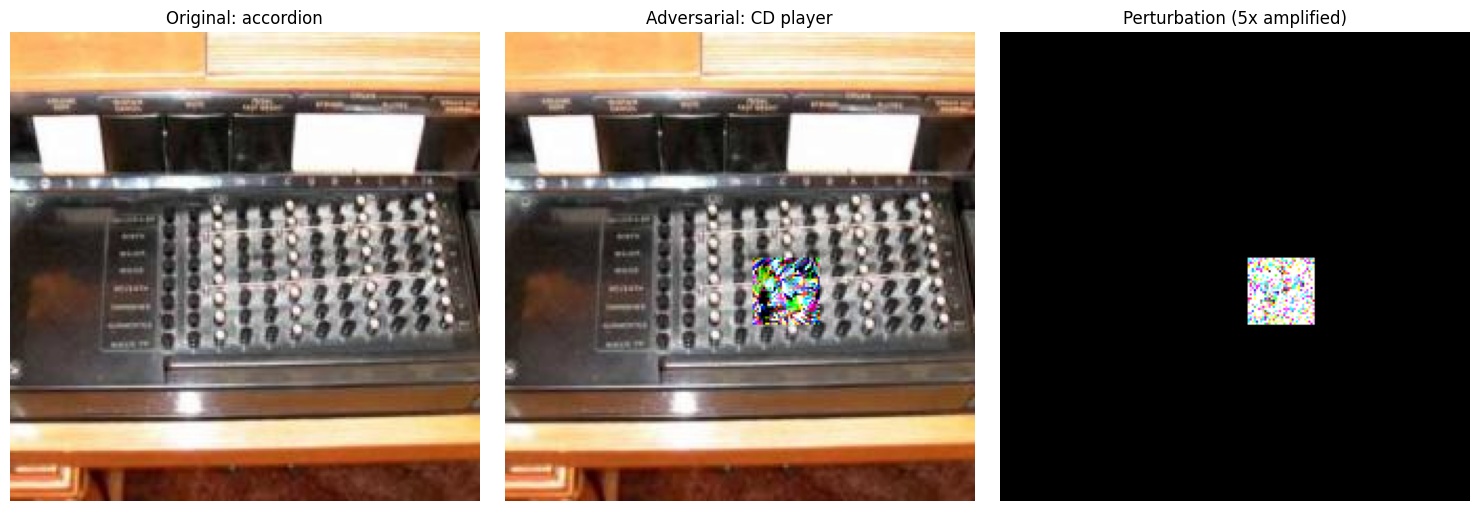

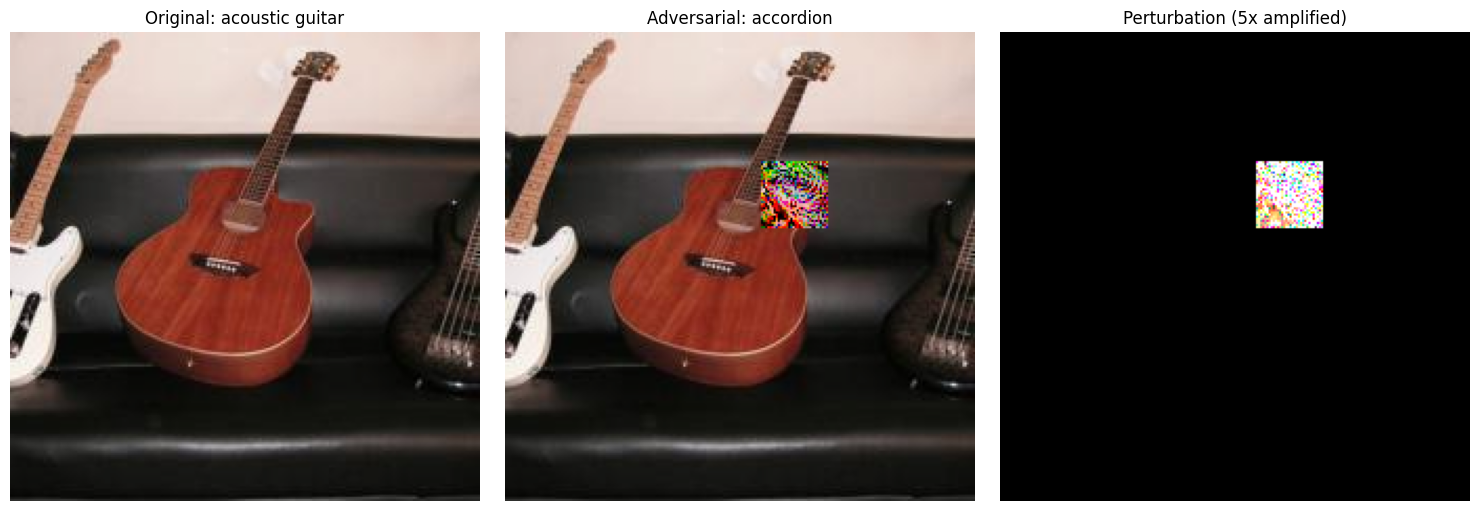

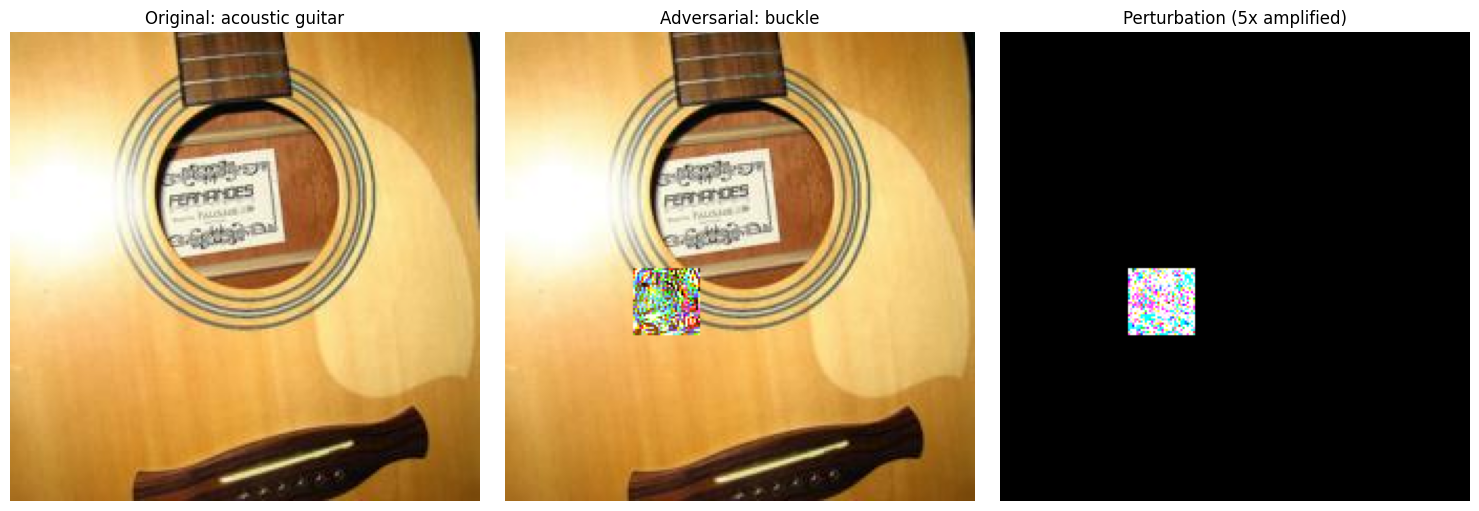


📊 Evaluating patch attack accuracy...

✅ Adversarial Test Set 3 (Patch attack with AMP, ε = 0.5)
Top-1 Accuracy: 1.00%
Top-5 Accuracy: 44.20%
Top-1 Attack Success Rate: 99.00%
Top-5 Attack Success Rate: 55.80%


In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
import random
from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings("ignore")

# Load model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').cuda().eval()

# Load label indices
with open("/content/TestData/labels_list.json", "r") as f:
    labels = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in labels]
class_names = [x.split(":")[1].strip() for x in labels]

# Normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=mean, std=std)
unnormalize = transforms.Normalize(mean=-mean / std, std=1 / std)

to_tensor = transforms.ToTensor()

# Enhanced PGD patch parameters
epsilon = 0.5
alpha = 0.05
num_steps = 100
patch_size = 32
num_restarts = 8
num_target_classes = 10  # Target more classes to improve top-5 attack

# Dataset setup
root = "/content/TestData"
dataset = torchvision.datasets.ImageFolder(root=root, transform=lambda x: x)

# Output dir
adv_save_dir = "Adversarial_Test_Set_3"
os.makedirs(adv_save_dir, exist_ok=True)

adv_images = []
orig_images = []
true_labels = []
adv_labels = []

print(f"🚀 Running mixed precision patch attack targeting both top-1 and top-5 accuracy...")
print(f"Parameters: ε={epsilon}, patch_size={patch_size}, steps={num_steps}, restarts={num_restarts}")
print(f"Using automatic mixed precision for faster processing")

# Initialize AMP gradient scaler
scaler = GradScaler()

for i, (img_pil, label) in enumerate(tqdm(dataset)):
    raw = to_tensor(img_pil).unsqueeze(0).cuda()
    orig = raw.clone()
    _, _, H, W = raw.shape

    # Create patch mask with center bias
    patch_mask = torch.zeros_like(raw)

    # Single patch - biased toward center
    center_x, center_y = W//2, H//2
    max_offset = min(W, H)//6  # Tighter center focus
    x = center_x + random.randint(-max_offset, max_offset) - patch_size//2
    y = center_y + random.randint(-max_offset, max_offset) - patch_size//2
    x = max(0, min(W-patch_size, x))
    y = max(0, min(H-patch_size, y))
    patch_mask[:, :, y:y+patch_size, x:x+patch_size] = 1.0

    best_adv = orig.clone()
    best_dual_score = torch.tensor(-float("inf")).cuda()

    # Find initial prediction to identify promising target classes
    with torch.no_grad(), autocast():
        initial_output = model(normalize(orig))[:, imagenet_indices]
        initial_probs = torch.softmax(initial_output.squeeze(), dim=0)

        # Get all classes except the true class
        all_classes = torch.arange(len(imagenet_indices), device='cuda')
        wrong_classes = all_classes[all_classes != label]

        # Get top predicted classes excluding true class
        initial_probs_clone = initial_probs.clone()
        initial_probs_clone[label] = 0  # Zero out true class
        confusing_classes = initial_probs_clone.argsort(descending=True)[:num_target_classes]

    # Initialize momentum
    momentum = torch.zeros_like(orig).cuda()

    for restart in range(num_restarts):
        # Different strategies for different restarts
        if restart < num_restarts // 2:
            # First half of restarts: target most confusing classes
            target_classes = confusing_classes
        else:
            # Second half: randomly sample from all wrong classes for diversity
            perm = torch.randperm(len(wrong_classes), device='cuda')
            target_classes = wrong_classes[perm[:num_target_classes]]

        # Learning rate schedule
        alpha_schedule = lambda step: alpha * (1.0 - 0.8 * (step/num_steps))

        # Initialize with random noise in patch area
        rand_noise = torch.empty_like(raw).uniform_(-epsilon, epsilon) * patch_mask
        perturbed = torch.clamp(orig + rand_noise, 0, 1).detach().requires_grad_(True)

        # Reset momentum for each restart
        momentum = torch.zeros_like(orig).cuda()

        for step in range(num_steps):
            # Current alpha value
            current_alpha = alpha_schedule(step)

            # Forward pass with mixed precision
            with autocast():
                normed = normalize(perturbed)
                output = model(normed)
                masked_output = output[:, imagenet_indices]

                # Get probability distribution
                probs = torch.softmax(masked_output.squeeze(), dim=0)

                # Calculate margins for targeted classes vs true class
                margins = []
                for target_idx in target_classes:
                    margin = probs[target_idx] - probs[label]
                    margins.append(margin)

                # Sort margins to get the 5th best
                margins = torch.stack(margins)
                margins_sorted, _ = torch.sort(margins, descending=True)

                # Fifth margin is key for pushing out of top-5
                fifth_margin = margins_sorted[min(4, len(margins_sorted)-1)]

                # Top-1 component (strongest wrong class)
                top1_margin = margins_sorted[0]

                # Combined loss with emphasis on top-5
                loss = -(0.3 * top1_margin + 0.7 * fifth_margin)

            # Compute gradient with AMP
            model.zero_grad()
            scaler.scale(loss).backward()

            # Apply momentum to gradient (in full precision)
            grad = perturbed.grad.detach()
            momentum = 0.9 * momentum - 0.1 * grad

            # Normalize gradient
            momentum_norm = momentum / (momentum.abs().mean(dim=(1, 2, 3), keepdim=True) + 1e-8)

            # Update (always in full precision)
            update = current_alpha * momentum_norm.sign() * patch_mask
            perturbed = perturbed + update

            # Project back to epsilon-ball and valid image range
            delta = torch.clamp(perturbed - orig, min=-epsilon, max=epsilon) * patch_mask
            perturbed = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)

        # Evaluate this restart
        with torch.no_grad(), autocast():
            normed_final = normalize(perturbed.detach())
            final_output = model(normed_final)[:, imagenet_indices]

            # Get top-5 predictions
            _, top5 = final_output.topk(5, dim=1)
            top5_flat = top5.view(-1)

            # Score based on top-1 and top-5 success
            top1_success = 1.0 if top5[0, 0] != label else 0.0
            top5_success = 1.0 if label not in top5_flat else 0.0

            # Combined score with emphasis on top-5
            dual_score = top1_success * 0.3 + top5_success * 0.7

            # Always take example with better score
            if dual_score > best_dual_score:
                best_dual_score = dual_score
                best_adv = perturbed.detach()

            # If tied on dual score, use margin-based selection
            elif dual_score == best_dual_score:
                # Check which example has better margins
                final_probs = torch.softmax(final_output.squeeze(), dim=0)

                # Get current fifth margin
                current_margins = []
                for target_idx in target_classes:
                    margin = final_probs[target_idx] - final_probs[label]
                    current_margins.append(margin)
                current_margins = torch.stack(current_margins)
                current_margins_sorted, _ = torch.sort(current_margins, descending=True)
                current_fifth_margin = current_margins_sorted[min(4, len(current_margins_sorted)-1)]

                # Get best example's fifth margin
                with autocast():
                    best_output = model(normalize(best_adv))[:, imagenet_indices]
                    best_probs = torch.softmax(best_output.squeeze(), dim=0)

                best_margins = []
                for target_idx in target_classes:
                    margin = best_probs[target_idx] - best_probs[label]
                    best_margins.append(margin)
                best_margins = torch.stack(best_margins)
                best_margins_sorted, _ = torch.sort(best_margins, descending=True)
                best_fifth_margin = best_margins_sorted[min(4, len(best_margins_sorted)-1)]

                # Take example with better fifth margin
                if current_fifth_margin > best_fifth_margin:
                    best_adv = perturbed.detach()

    # Save adversarial image
    save_path = os.path.join(adv_save_dir, f"adv_{i:04d}.png")
    save_image(best_adv.cpu().squeeze(), save_path)

    # Evaluation
    with torch.no_grad(), autocast():
        normed_adv = normalize(best_adv)
        pred = model(normed_adv)
        masked_pred = pred[:, imagenet_indices]
        pred_top1 = masked_pred.argmax(dim=1)

    adv_images.append(normed_adv.cpu())
    orig_images.append(normalize(orig).cpu())
    true_labels.append(label)
    adv_labels.append(pred_top1.item())



print("✅ Adversarial images saved to:", adv_save_dir)

# Convert lists to tensors
adv_images = torch.cat(adv_images)
orig_images = torch.cat(orig_images)
true_labels = torch.tensor(true_labels)
adv_labels = torch.tensor(adv_labels)

# Visualize examples - focusing on top-5 removal
print("\n🔍 Visualizing examples where true class is removed from top-5:")

success_indices = []
with torch.no_grad(), autocast():
    for i in range(len(adv_images)):
        batch = adv_images[i].unsqueeze(0).cuda()
        target = true_labels[i].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)

        # Check if true class is NOT in top-5
        if target not in top5[0]:
            success_indices.append(i)
            if len(success_indices) >= 5:  # Get first 5 successful examples
                break

# If we don't have enough top-5 successes, fall back to top-1 misclassifications
if len(success_indices) < 5:
    misclassified = (adv_labels != true_labels).nonzero(as_tuple=True)[0]
    remaining_needed = 5 - len(success_indices)
    for i in misclassified:
        if i not in success_indices:
            success_indices.append(i)
            remaining_needed -= 1
            if remaining_needed == 0:
                break

# Visualize examples
for i in success_indices[:5]:
    orig = unnormalize(orig_images[i]).permute(1, 2, 0).numpy()
    adv = unnormalize(adv_images[i]).permute(1, 2, 0).numpy()
    diff = np.abs(adv - orig) * 5  # Amplify difference to visualize patch

    # Get model predictions
    with torch.no_grad(), autocast():
        # Original image
        orig_output = model(orig_images[i].unsqueeze(0).cuda())
        orig_masked = orig_output[:, imagenet_indices]
        _, orig_top5 = orig_masked.topk(5, dim=1)
        orig_top5_labels = [class_names[idx] for idx in orig_top5[0].cpu().numpy()]

        # Adversarial image
        adv_output = model(adv_images[i].unsqueeze(0).cuda())
        adv_masked = adv_output[:, imagenet_indices]
        _, adv_top5 = adv_masked.topk(5, dim=1)
        adv_top5_labels = [class_names[idx] for idx in adv_top5[0].cpu().numpy()]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(np.clip(orig, 0, 1))
    axs[0].set_title(f"Original: {class_names[true_labels[i]]}")
    axs[0].set_xlabel(f"Top-5: {', '.join(orig_top5_labels)}")
    axs[0].axis('off')

    axs[1].imshow(np.clip(adv, 0, 1))
    axs[1].set_title(f"Adversarial: {class_names[adv_labels[i]]}")
    axs[1].set_xlabel(f"Top-5: {', '.join(adv_top5_labels)}")
    axs[1].axis('off')

    axs[2].imshow(diff)
    axs[2].set_title("Perturbation (5x amplified)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(adv_save_dir, f"example_{i:04d}.png"))
    plt.show()

# Evaluate accuracy
print("\n📊 Evaluating patch attack accuracy...")

top1_correct, top5_correct = 0, 0
total = 0

with torch.no_grad(), autocast():
    for i in range(0, len(adv_images), 64):
        batch = adv_images[i:i+64].cuda()
        targets = true_labels[i:i+64].cuda()
        outputs = model(batch)
        masked_outputs = outputs[:, imagenet_indices]

        _, top5 = masked_outputs.topk(5, dim=1)
        top1 = top5[:, 0]

        top1_correct += (top1 == targets).sum().item()
        top5_correct += sum([targets[j] in top5[j] for j in range(len(targets))])
        total += targets.size(0)

adv_top1_acc = top1_correct / total
adv_top5_acc = top5_correct / total

# Calculate attack success rates
top1_success_rate = 1 - adv_top1_acc
top5_success_rate = 1 - adv_top5_acc

print(f"\n✅ Adversarial Test Set 3 (Patch attack with AMP, ε = {epsilon})")
print(f"Top-1 Accuracy: {adv_top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc * 100:.2f}%")
print(f"Top-1 Attack Success Rate: {top1_success_rate * 100:.2f}%")
print(f"Top-5 Attack Success Rate: {top5_success_rate * 100:.2f}%")